In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
import cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf;
from tqdm import tqdm
import time

In [2]:
path = os.getcwd()
path

'/notebooks'

In [3]:
# To speed up the notebook, set this value to True to skip intermediate demo steps and only run full pipeline at the end of this notebook
skip_intermediate_demo = True

## Load data

LFW subset locally downloaded

In [4]:
# Path to the directory containing the subset of LFW dataset
# dataset = 'lfw_10classes_20images'
# dataset = 'lfw_30classes_20images'
# dataset = 'lfw_10images'
dataset = 'lfw_original' # crashes the kernel, try in Paperspace!
data_path = path + '/data/' + dataset + '/'

In [5]:
# Load the subset data into a NumPy array
data = []
original_images = []
targets = []
targets = []
for subdir in os.listdir(data_path):
    subdir_path = os.path.join(data_path, subdir)
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, file)
            if os.path.isfile(file_path):
                img = cv2.imread(file_path, cv2.IMREAD_COLOR)
                RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                data.append(RGB_img.flatten())
                original_images.append(RGB_img)
                targets.append(subdir)

data = np.array(data)
original_images = np.array(original_images)

### Explore data

In [6]:
# introspect the images arrays to find the shapes (for plotting)
n, w, h, c = original_images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = data
n_features = X.shape[1]

# the label to predict is the id of the person
target_names = targets
target_names_unique = [target_name for target_name in set(target_names)]
y = LabelEncoder().fit_transform(target_names.copy())
target_names_first_index = [np.where(y == label)[0][0] for label in np.unique(y)]
target_names_first_index.sort()

n_classes = len(target_names_unique)

In [7]:
# Print the shape of the data array
print('Data shape:', data.shape)

# Print the list of subdirectories and the number of images per subdirectory
subdir_counts = {subdir: targets.count(subdir) for subdir in set(targets)}
print('Subdirectory counts (unordered):', subdir_counts,'\n')

print(f"There are {n} images in the dataset, {13233 - n} less than the original dataset (of 13233).")
print(f"Each image is {w} pixels wide and {h} pixels tall, with {c} channels (RGB).")
print(f"In total this gives us {n_features} features per image.")
print(f"There are {n_classes} unique targets (classes) in the dataset.")

Data shape: (13233, 187500)
Subdirectory counts (unordered): {'Larry_Nichols': 1, 'Gene_Autry': 1, 'Abel_Pacheco': 4, 'Arlen_Specter': 3, 'Andrew_Luster': 1, 'Max_Mosley': 1, 'Christopher_Russell': 1, 'Jennie_Garth': 1, 'George_Karl': 2, 'Christopher_Amolsch': 1, 'Baz_Luhrmann': 1, 'Abid_Hamid_Mahmud_Al-Tikriti': 3, 'Enrique_Bolanos': 5, 'Allan_Kemakeza': 1, 'Thomas_OBrien': 9, 'Darrell_Royal': 1, 'Mel_Gibson': 2, 'Amy_Redford': 1, 'Jane_Walker_Wood': 1, 'Paul_Johnson': 1, 'Wim_Duisenberg': 1, 'Hank_Aaron': 1, 'Nate_Blackwell': 1, 'Alex_Popov': 1, 'Sam_Bith': 3, 'Eduard_Shevardnadze': 5, 'Khader_Rashid_Rahim': 1, 'Mark_Hamister': 2, 'Sandra_Milo': 1, 'Hubert_Green': 1, 'Alexandra_Pelosi': 1, 'Percy_Gibson': 1, 'Arturo_Gatti': 3, 'James_Wattana': 1, 'Mehmet_Ali_Sahin': 1, 'Ann_Godbehere': 1, 'Lenny_Wilkens': 3, 'Wilbert_Foy': 1, 'Mick_Jagger': 5, 'Ron_Lantz': 1, 'Jimmy_Gurule': 1, 'Andy_Perez': 1, 'Doris_Schroeder': 4, 'Laura_Hernandez': 2, 'Hisham_Halawi': 1, 'Suzanne_Somers': 1, 'Geor

In [8]:
original_images.shape

(13233, 250, 250, 3)

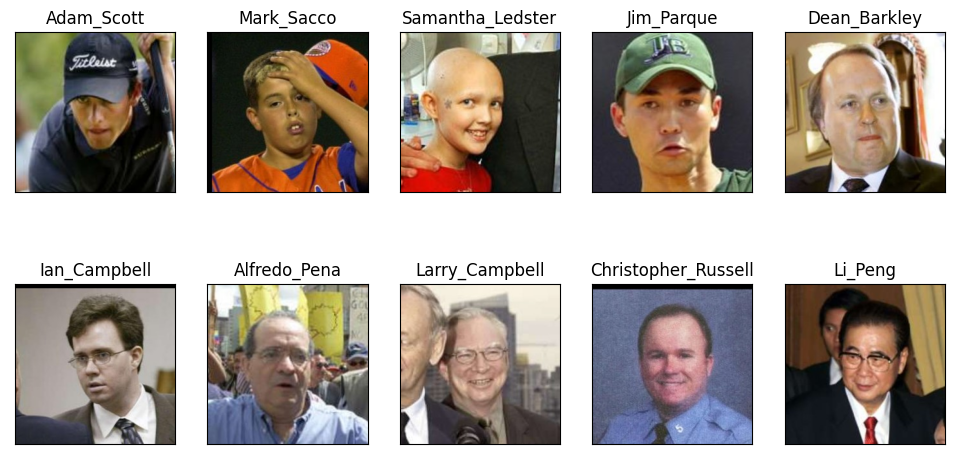

In [9]:
plot_images = original_images[target_names_first_index[0:10]]
label_array = np.array(target_names)[target_names_first_index[0:10]]

# Create a figure with a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# Iterate over the subplots and plot each image with its corresponding label
for i, ax in enumerate(axes.flat):
    ax.imshow(plot_images[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(label_array[i]))

# Show the figure
plt.show()

In [10]:
original_images.shape

(13233, 250, 250, 3)

In [11]:
# the channels: RGB
original_images[0,0,0,:]

array([115, 129,  68], dtype=uint8)

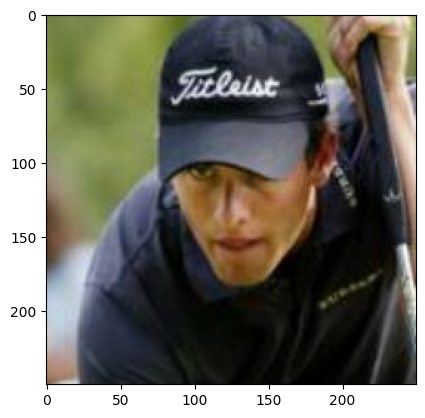

In [12]:
plt.imshow(original_images[0])

(array([[ 0.,  0.,  0., ..., 43.,  3.,  0.],
        [ 0.,  0.,  0., ..., 46.,  0.,  0.],
        [ 0.,  0.,  0., ..., 47.,  0.,  0.],
        ...,
        [ 0.,  0., 24., ..., 27., 32., 35.],
        [ 0.,  0., 13., ..., 23., 30., 38.],
        [ 0.,  0., 14., ..., 21., 25., 44.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 250 BarContainer objects>)

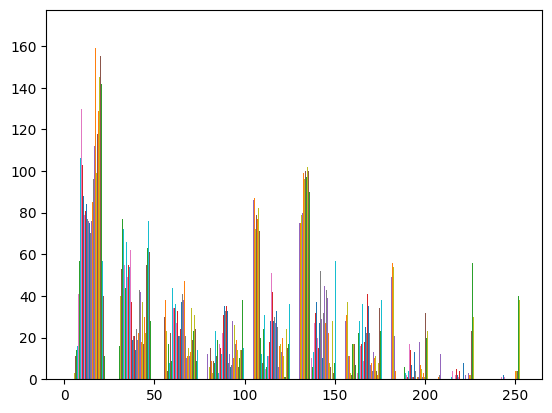

In [13]:
plt.hist(original_images[0,:,:,0])

In [14]:
def plot_original_faces(indices, max_faces=None, start=0):
    # Get the relevant images from the original_images array
    relevant_images = original_images[indices[start:]]
    
    # If max_faces is set, limit the number of images to plot
    if max_faces is not None:
        relevant_images = relevant_images[:max_faces]
    
    # Determine the number of rows and columns to use in the plot
    num_images = relevant_images.shape[0]
    num_cols = min(num_images, 5)
    num_rows = int(np.ceil(num_images / num_cols))
    
    # Create the plot and add subplots for each image
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axs = axs.flatten()
    for i, img in enumerate(relevant_images):
        axs[i].imshow(img)
        axs[i].axis('off')
    
    # Remove any unused subplots
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()

## Preprocess the images

## Face detection
Based on BlazeFace, taken inspiration from [this repo](https://github.com/ibaiGorordo/BlazeFace-TFLite-Inference). 

In [15]:
from importlib import reload
from src.blazeface import BlazeFace, BlazeFaceResults
# reload(src.BlazeFace.BlazeFace)
# reload(BlazeFaceResults)

In [16]:
blazeface_model = BlazeFace(model_type='sparse')
blazeface_model.input_details

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


[{'name': 'input_1',
  'index': 0,
  'shape': array([  1, 192, 192,   3], dtype=int32),
  'shape_signature': array([  1, 192, 192,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [17]:
original_test_image = original_images[0]
test_image = blazeface_model.preprocess_input(original_test_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


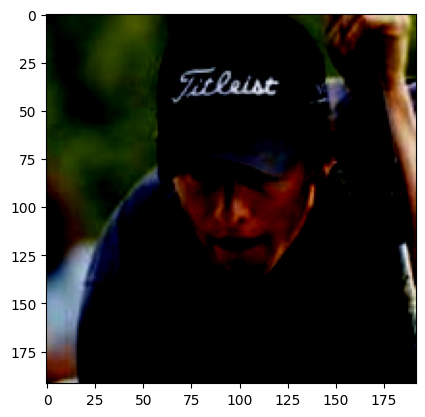

In [18]:
plt.imshow(test_image.numpy().squeeze()) if test_image.shape[0] == 1 else plt.imshow(test_image[0])

#### Extract detections

In [19]:
face_detection_results = blazeface_model.detect_faces(original_test_image)

In [20]:
face_detection_results.boxes

array([], shape=(0, 4), dtype=float64)

In [21]:
face_detection_results.keypoints

array([], shape=(0, 6, 2), dtype=float64)

In [22]:
face_detection_results.scores

array([], dtype=float32)

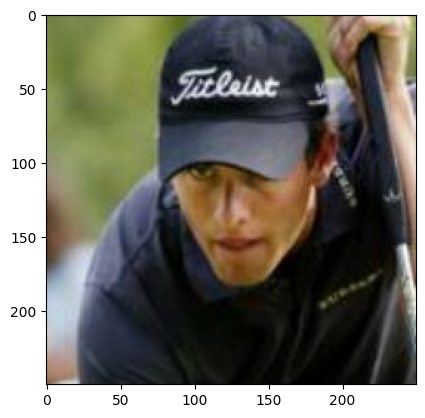

In [23]:
plt.imshow(original_test_image)

In [24]:
plot_test_image = blazeface_model.draw_detections_single_image(original_test_image, face_detection_results)

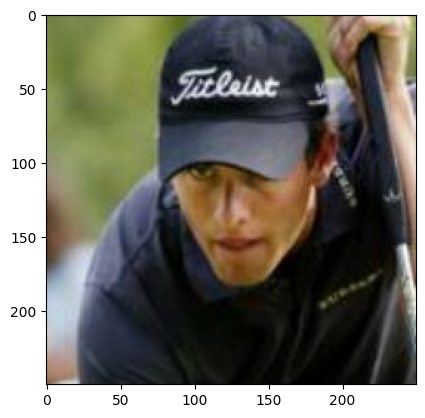

In [25]:
plt.imshow(plot_test_image)

#### Test detections

In [26]:
if not skip_intermediate_demo:
    blazeface_dense_model = BlazeFace(model_type='dense', score_threshold=0.6)

    face_detection_results = []
    detected_faces_count = 0
    detected_faces_indices = []
    undetected_faces_count = 0
    undetected_faces_indices = []
    double_detected_faces_count = 0
    double_detected_faces_indices = []

    for i in tqdm(range(original_images.shape[0])):
        face_detection_results.append(blazeface_dense_model.detect_faces(original_images[i]))
        if face_detection_results[-1].boxes.shape[0] > 0:
            detected_faces_count += 1
            detected_faces_indices.append(i)
            if face_detection_results[-1].boxes.shape[0] > 1:
                double_detected_faces_count += 1
                double_detected_faces_indices.append(i)

        else:
            undetected_faces_count += 1
            undetected_faces_indices.append(i)

    print(f"For the dense model:")
    print(f"Detected faces: {detected_faces_count} out of {original_images.shape[0]} ({detected_faces_count/original_images.shape[0]*100:.2f}%). Undetected faces: {undetected_faces_count} out of {original_images.shape[0]} ({undetected_faces_count/original_images.shape[0]*100:.2f}%).")
    print(f"Double detected faces: {double_detected_faces_count} out of {original_images.shape[0]} ({double_detected_faces_count/original_images.shape[0]*100:.2f}%).")

In [27]:
if not skip_intermediate_demo:
    blazeface_model = BlazeFace(model_type='sparse', score_threshold=0.6)

    face_detection_results = []
    detected_faces_count = 0
    detected_faces_indices = []
    undetected_faces_count = 0
    undetected_faces_indices = []
    double_detected_faces_count = 0
    double_detected_faces_indices = []

    for i in tqdm(range(original_images.shape[0])):
        face_detection_results.append(blazeface_model.detect_faces(original_images[i]))
        if face_detection_results[-1].boxes.shape[0] > 0:
            detected_faces_count += 1
            detected_faces_indices.append(i)
            if face_detection_results[-1].boxes.shape[0] > 1:
                double_detected_faces_count += 1
                double_detected_faces_indices.append(i)

        else:
            undetected_faces_count += 1
            undetected_faces_indices.append(i)

    print(f"Detected faces: {detected_faces_count} out of {original_images.shape[0]} ({detected_faces_count/original_images.shape[0]*100:.2f}%). Undetected faces: {undetected_faces_count} out of {original_images.shape[0]} ({undetected_faces_count/original_images.shape[0]*100:.2f}%).")
    print(f"Double detected faces: {double_detected_faces_count} out of {original_images.shape[0]} ({double_detected_faces_count/original_images.shape[0]*100:.2f}%).")

In [28]:
def plot_face_detections(indices, title, images=original_images, labels=target_names):
    
    plot_images = images[indices]
    label_array = np.array(labels)[indices]
    
    num_images = plot_images.shape[0]

    for i in range(num_images):
        detection_result = blazeface_model.detect_faces(plot_images[i])
        plot_images[i] = blazeface_model.draw_detections_single_image(plot_images[i], detection_result)

    # Calculate the number of rows and columns for the grid
    cols = min(5, num_images)
    rows = int(np.ceil(num_images / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

    # Customize the background color and text color
    bg_color = "#222222"
    text_color = "#ffffff"

    fig.patch.set_facecolor(bg_color)

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            # Plot the image
            if plot_images.shape[-1] == 3:
                ax.imshow(plot_images[i].astype(np.uint8))
            else:
                ax.imshow(plot_images[i], cmap='gray')
            
            # Set the title with the corresponding label
            ax.set_title(f"{label_array[i]}", fontsize=12, color=text_color, y=1.02)
        
        # Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # Set the background color for each subplot
        ax.set_facecolor(bg_color)

        # Set the color of the spines (border of the subplots)
        ax.spines['bottom'].set_color(text_color)
        ax.spines['top'].set_color(text_color)
        ax.spines['right'].set_color(text_color)
        ax.spines['left'].set_color(text_color)

    fig.suptitle(title, fontsize=20, y=1.02 + 0.02 * rows, color=text_color)
    plt.tight_layout(rect=[0, 0, 1, 1 - 0.04 * rows])
    plt.show()


In [29]:
if not skip_intermediate_demo:
    plot_face_detections(target_names_first_index, "Detected faces")

In [30]:
if not skip_intermediate_demo:
    plot_face_detections(undetected_faces_indices, "Undetected faces")

In [31]:
if not skip_intermediate_demo:
    plot_face_detections(double_detected_faces_indices, "Double face detections")

## Face alignment

For now I'm simply following [this github](https://sefiks.com/2020/02/23/face-alignment-for-face-recognition-in-python-within-opencv/) script from insightface.

In [32]:
from src.face_alignment import SimpleFaceAlignment

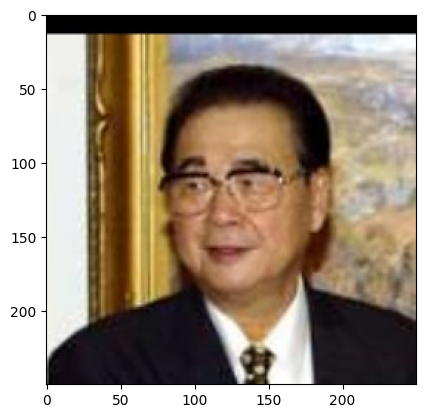

In [33]:
test_image = original_images[18]
test_image_face_detection_result = blazeface_model.detect_faces(test_image)
plt.imshow(test_image)

In [34]:
face_aligner = SimpleFaceAlignment()

In [35]:
test_aligned_image_results = face_aligner.crop_and_align(test_image, test_image_face_detection_result)
test_aligned_image_results.aligned_faces[0].shape

(112, 112, 3)

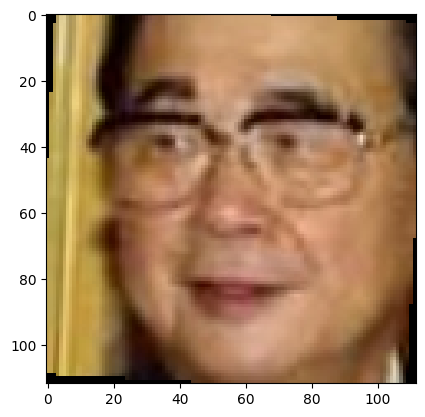

In [36]:
plt.imshow(test_aligned_image_results.aligned_faces[0])

In [37]:
test_aligned_image_results

AlignedFaceResults(
  num_faces=1,  # Number of detected faces
  eye_coordinates=[((35, 41), (76, 39))],  # (Left eye, Right eye)(from viewer perspective) coordinates for each face (x,y)
  rotation_angles=[2.792702365713353],  # Rotation angles for each face alignment
  relative_face_sizes=[0.200704]  # Relative size of each face compared to the original image
)

#### Test alignments

In [38]:
if not skip_intermediate_demo:
    face_detection_results = []
    face_alignment_results = []

    for idx in tqdm(range(original_images.shape[0])):
        image = original_images[idx]
        face_detection_results.append(blazeface_model.detect_faces(image))
        if (face_detection_results[-1].boxes.shape[0] > 0) & (face_detection_results[-1].boxes.shape[0] < 2):
            face_alignment_results.append(face_aligner.crop_and_align(image, face_detection_results[idx]))
        else:
            face_alignment_results.append(None)
    

In [39]:
def plot_aligned_faces(aligned_face_results_list, max_faces=None, indices=None, start=0):
    if indices is not None:
        aligned_face_results_list = [aligned_face_results_list[i] for i in indices]

    aligned_faces = [
        face
        for aligned_face_results in aligned_face_results_list
        if aligned_face_results is not None
        for face in aligned_face_results.aligned_faces
    ]

    if start > 0:
        aligned_faces = aligned_faces[start:]

    if max_faces is not None:
        aligned_faces = aligned_faces[:max_faces]

    num_faces = len(aligned_faces)
    cols = min(5, num_faces)
    rows = int(np.ceil(num_faces / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    fig.suptitle("Aligned Faces", fontsize=20, y=1.02)

    for i, ax in enumerate(axes.flat):
        if i < num_faces:
            if aligned_faces[i].shape[-1] == 3:
                ax.imshow(aligned_faces[i].astype(np.uint8))
            else:
                ax.imshow(aligned_faces[i], cmap='gray')
            ax.set_title(f"Face {i + 1 + start}")

        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()


In [40]:
if not skip_intermediate_demo:
    plot_aligned_faces(face_alignment_results, max_faces=50)

In [41]:
if not skip_intermediate_demo:
    plot_aligned_faces(face_alignment_results, max_faces=50, indices=target_names_first_index)

## Face transformation

Follows [this](https://github.com/deepinsight/insightface/blob/be3f7b3e0e635b56d903d845640b048247c41c90/common/face_align.py) example.

In [42]:
from src.face_alignment import ArcFaceAlignment

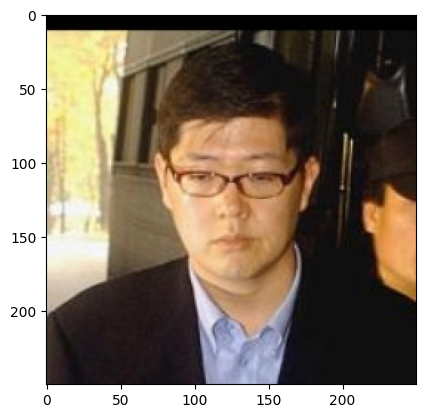

In [43]:
test_image = original_images[25]
plt.imshow(test_image)

In [44]:
test_image_face_detection_result = blazeface_model.detect_faces(test_image)
if not skip_intermediate_demo:
    test_image_face_detection_result

In [45]:
test_image.shape

(250, 250, 3)

In [46]:
test_image_landmarks_relative_full = test_image_face_detection_result.keypoints[0][:4]
test_image_landmarks_absolute_full = (test_image_landmarks_relative_full * 250).astype(np.int32)
if not skip_intermediate_demo:
    test_image_landmarks_relative_full

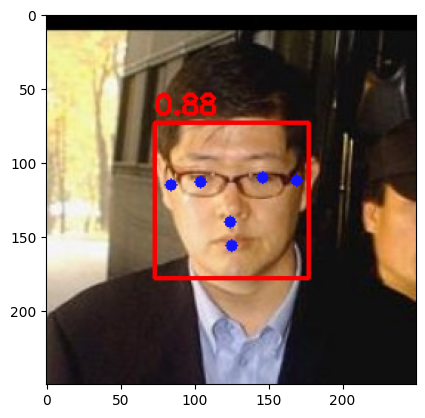

In [47]:
test_image_face = test_image.copy()
test_image_face = blazeface_model.draw_detections_single_image(test_image_face, test_image_face_detection_result)
plt.imshow(test_image_face)

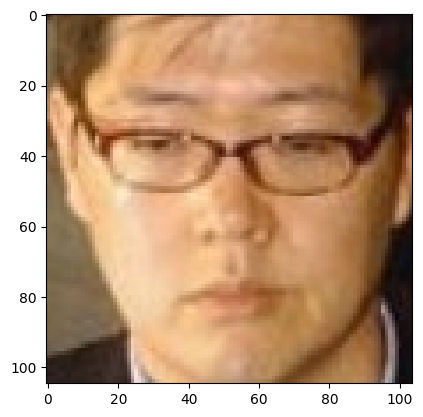

In [48]:
crop_face = SimpleFaceAlignment()
test_image_cropped, xmin, ymin = crop_face.crop(test_image, test_image_face_detection_result, 250,250)
test_image_cropped = test_image_cropped[0][:112,:112]
plt.imshow(test_image_cropped)

In [49]:
arcface_align = ArcFaceAlignment()
test_image_align_result = arcface_align.crop_and_align(test_image, test_image_face_detection_result)
test_image_align_result

AlignedFaceResults(
  num_faces=1,  # Number of detected faces
  eye_coordinates=None,  # (Left eye, Right eye)(from viewer perspective) coordinates for each face (x,y)
  rotation_angles=None,  # Rotation angles for each face alignment
  relative_face_sizes=[0.200704]  # Relative size of each face compared to the original image
)

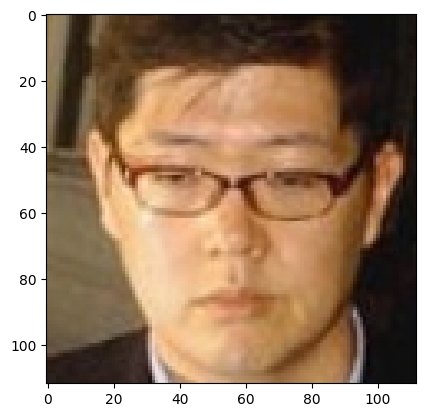

In [50]:
plt.imshow(test_image_align_result.aligned_faces[0])

### Test transformations

In [51]:
if not skip_intermediate_demo:
    face_detection_results = []
    face_transformation_results = []

    for idx in tqdm(range(original_images.shape[0])):
        image = original_images[idx]
        face_detection_results.append(blazeface_model.detect_faces(image))
        if (face_detection_results[-1].boxes.shape[0] > 0) & (face_detection_results[-1].boxes.shape[0] < 2):
            face_transformation_results.append(arcface_align.crop_and_align(image, face_detection_results[idx]))
        else:
            face_transformation_results.append(None)
        

In [52]:
if not skip_intermediate_demo:
    plot_aligned_faces(face_transformation_results, max_faces=30, start=40)

In [53]:
if not skip_intermediate_demo:
    plot_aligned_faces(face_alignment_results, max_faces=30, start=40)

## Face normalization (optional)

I can use a face mesh model like the one from [MediaPipe](https://github.com/google/mediapipe/blob/master/docs/solutions/face_mesh.md) to normalize faces, as shown [here](https://sefiks.com/2022/05/29/normalization-for-facial-recognition-with-mediapipe/). This probably gives better results, since the bounding boxes and landmarks from BlazeFace are not super accurate.

In [54]:
from src.face_alignment import FaceMeshAlignment

In [55]:
face_mesh_model = FaceMeshAlignment(crop=True)

In [56]:
test_image = original_images[18]
test_image_face_detection_result = blazeface_model.detect_faces(test_image)
test_image_aligned_faces = face_aligner.crop_and_align(test_image, test_image_face_detection_result)

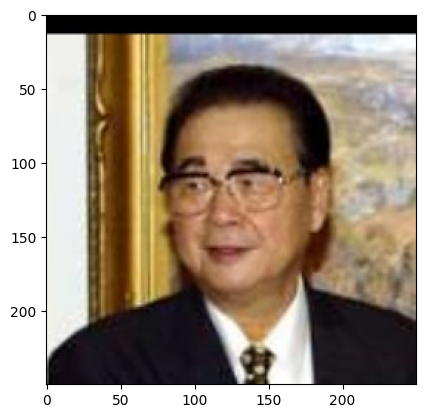

In [57]:
plt.imshow(test_image)

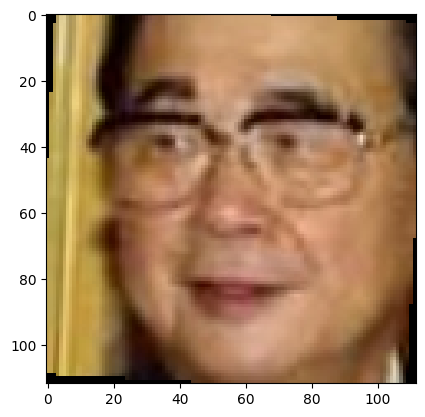

In [58]:
plt.imshow(test_image_aligned_faces.aligned_faces[0])

In [59]:
test_image_normalized_faces = face_mesh_model.normalize_faces(test_image, test_image_face_detection_result)

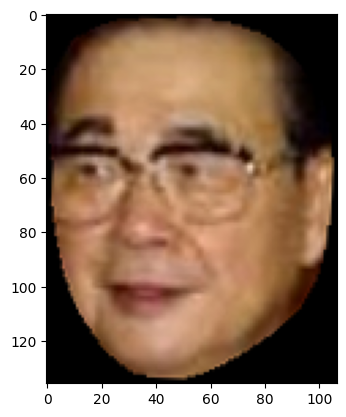

In [60]:
plt.imshow(test_image_normalized_faces.aligned_faces[0])

In [61]:
# run face detection and alignment on all images again
if not skip_intermediate_demo:
    face_detection_results = []
    face_normalization_results = []

    for idx in tqdm(range(original_images.shape[0])):
        image = original_images[idx]
        face_detection_results.append(blazeface_model.detect_faces(image))
        if (face_detection_results[-1].boxes.shape[0] > 0) & (face_detection_results[-1].boxes.shape[0] < 2):
            face_normalization_results.append(face_mesh_model.normalize_faces(image, face_detection_results[idx]))
        else:
            face_normalization_results.append(None)

In [62]:
if not skip_intermediate_demo:
    plot_aligned_faces(face_normalization_results, max_faces=20)

In [63]:
if not skip_intermediate_demo:
    plot_aligned_faces(face_alignment_results, max_faces=20)

In [64]:
if not skip_intermediate_demo:
    plot_aligned_faces(face_normalization_results, max_faces=20, start=20)

In [65]:
if not skip_intermediate_demo:
    plot_aligned_faces(face_alignment_results, max_faces=20, start=20)

In [66]:
if not skip_intermediate_demo:
    plot_aligned_faces(face_normalization_results, max_faces=100, start=100)

## Face embeddings

In [67]:
from src.mobilefacenet import MobileFaceNet

In [69]:
mobilefacenet_model = MobileFaceNet(model_type="ente_web")
# mobilefacenet_quantized_model = MobileFaceNet(model_type="quantized")

In [70]:
mobilefacenet_model.interpreter.get_input_details()

[{'name': 'input',
  'index': 369,
  'shape': array([  1, 112, 112,   3], dtype=int32),
  'shape_signature': array([  1, 112, 112,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [71]:
mobilefacenet_model.interpreter.get_output_details()

[{'name': 'embeddings',
  'index': 368,
  'shape': array([  1, 192], dtype=int32),
  'shape_signature': array([  1, 192], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [72]:
# run face detection and alignment/normalization on all images again
face_detection_results = []
face_alignment_results = []
# face_normalization_results = []

for idx in tqdm(range(original_images.shape[0])):
    image = original_images[idx]
    face_detection_results.append(blazeface_model.detect_faces(image))
    if face_detection_results[-1].boxes.shape[0] > 0:
        face_alignment_results.append(arcface_align.crop_and_align(image, face_detection_results[idx]))
        # face_normalization_results.append(face_mesh_model.normalize_faces(image, face_detection_results[idx]))
    else:
        face_alignment_results.append(None)
        # face_normalization_results.append(None)

100%|██████████| 13233/13233 [05:12<00:00, 42.29it/s]


In [73]:
# create face embeddings using unquantized MobileFaceNet model
face_embeddings = []
# face_embeddings_normalized = []

for idx in tqdm(range(original_images.shape[0])):
    if (face_alignment_results[idx] is not None): # if face was detected
        if (face_alignment_results[idx].num_faces ==1): # if only one face was detected
            face_embeddings.append(mobilefacenet_model.extract_embedding(face_alignment_results[idx].aligned_faces[0]))
        else:
            face_embeddings.append(None)
    else:
        face_embeddings.append(None)
    # if (face_normalization_results[idx] is not None): # if face was detected
    #     if (face_normalization_results[idx].num_faces ==1): # if only one face was detected
    #         face_embeddings_normalized.append(mobilefacenet_model.extract_embedding(face_normalization_results[idx].aligned_faces[0]))

100%|██████████| 13233/13233 [05:21<00:00, 41.14it/s]


In [74]:
len(face_embeddings)

13233

In [76]:
face_embeddings_squeezed = [array[0] if array is not None else None for array in face_embeddings]

## Indexing the embeddings

### Quick approach with pandas

In [78]:
import sklearn

In [79]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize

In [80]:
face_embeddings_used = face_embeddings

# filtered_embeddings = [(idx, arr[0]) for idx, arr in enumerate(face_embeddings) if arr is not None]
filtered_embeddings = [(idx, arr[0]) for idx, arr in enumerate(face_embeddings_used) if arr is not None]

# Separate indices and data into two lists
original_indices, filtered_data_arrays = zip(*filtered_embeddings)

# Create a pandas DataFrame from the data arrays
df_embeddings = pd.DataFrame(filtered_data_arrays)

# Add the original index column
df_embeddings['original_index'] = original_indices

# Calculate the cosine distance matrix
cosine_dist_matrix = cosine_distances(df_embeddings.drop(columns=['original_index'])).astype(np.float64)
cosine_dist_matrix_more_precise = pairwise_distances(df_embeddings.drop(columns=['original_index']), metric='cosine').astype(np.float64)

norm_data = normalize(df_embeddings.drop(columns=['original_index']), norm='l2', axis=1)

In [81]:
df_embeddings

0         1         2         3         4         5         6  \
0      0.005858 -0.003509 -0.000289  0.000965  0.021136  0.057431 -0.084617   
1      0.001801 -0.002189  0.012241 -0.006132 -0.018429  0.106562 -0.016494   
2     -0.002121 -0.004889  0.009397  0.019920 -0.010480  0.088423  0.038228   
3     -0.003491  0.006220  0.002775  0.001467 -0.006890  0.012086  0.015544   
4      0.005725 -0.009464  0.004730 -0.011354  0.001078 -0.008725  0.065580   
...         ...       ...       ...       ...       ...       ...       ...   
12240 -0.017109  0.005807  0.007197  0.012791 -0.002327 -0.021521  0.094743   
12241 -0.011516  0.006598  0.006194  0.008982 -0.002204 -0.024264  0.008300   
12242  0.006560  0.002885  0.004227 -0.014209 -0.008032  0.096154 -0.005583   
12243  0.009829 -0.011898 -0.002125  0.009450  0.012728  0.046608 -0.068952   
12244 -0.001388 -0.000125  0.000164  0.016422 -0.014303  0.066754 -0.024066   

              7         8         9  ...       183       184       185  \
0     -0.065157 -0.135258 -0.111320  ...  0.003764 -0.107291 -0.039272   
1     -0.245005  0.039466  0.040352  ...  0.003107 -0.128568 -0.054940   
2     -0.384484  0.070988  0.068320  ... -0.000755  0.019247 -0.116923   
3      0.106613 -0.057675  0.059010  ...  0.003585 -0.082688 -0.124488   
4     -0.238014 -0.055743  0.009814  ...  0.002629 -0.041947  0.112164   
...         ...       ...       ...  ...       ...       ...       ...   
12240  0.141039  0.026416 -0.087525  ...  0.001422 -0.078158  0.068934   
12241  0.244595 -0.043651 -0.183213  ...  0.004525 -0.013391  0.180720   
12242  0.181609  0.042209  0.024466  ... -0.005082 -0.245631 -0.006635   
12243  0.155955  0.008079 -0.001098  ...  0.005327  0.041439 -0.008429   
12244  0.132028 -0.019293 -0.014630  ... -0.003037 -0.062583 -0.056929   

            186       187       188       189       190       191  \
0      0.035728 -0.061871 -0.006564 -0.057877  0.009328  0.011948   
1      0.101909 -0.062441  0.166819 -0.168305 -0.012886  0.005008   
2      0.053448  0.032927 -0.092271 -0.051720 -0.011610  0.002332   
3      0.074253  0.063362 -0.284380  0.062942 -0.010267  0.006154   
4     -0.038457 -0.000119  0.151203  0.061118  0.014590  0.019785   
...         ...       ...       ...       ...       ...       ...   
12240  0.066658 -0.088122 -0.024397  0.010495  0.015159 -0.002517   
12241  0.045687 -0.084826 -0.017131  0.002350  0.005057  0.002751   
12242 -0.049149 -0.000808  0.058071 -0.035052 -0.007270  0.010102   
12243 -0.037098 -0.038125 -0.182015 -0.008918  0.009266 -0.000148   
12244 -0.024973 -0.067812  0.113638 -0.091474  0.001878 -0.003259   

       original_index  
0                   1  
1                   2  
2                   3  
3                   4  
4                   5  
...               ...  
12240           13228  
12241           13229  
12242           13230  
12243           13231  
12244           13232  

[12245 rows x 193 columns]

### Solid approach with sqlite

## Clustering with HDBSCAN

In [83]:
# pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 37.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp39-cp39-linux_x86_64.whl size=3580361 sha256=7ffecef8d1ac24bdb2fcec4de74166a60a36de75db34a5ddda3d47323f02b1ff
  Stored in directory: /root/.cache/pip/wheels/d0/ff/97/ad3f429626365e542357cb9bd2c986bc9a88de946776c2a805
Successfully built hdbscan
Note: you may need to restart the kernel to use updated packages.


In [84]:
from hdbscan import HDBSCAN

In [87]:
# Perform HDBSCAN clustering

# # Try out values for the parameters
# minimum_cluster_size = 5
# minimum_samples = 1
# selection_epsilon = 0
# selection_method = 'eom'

# # My best values for the parameters
# minimum_cluster_size = 7
# minimum_samples = 1
# selection_epsilon = 0
# selection_method = 'eom'

# Default values for the parameters
minimum_cluster_size = 5
minimum_samples = 5
selection_epsilon = 0
selection_method = 'eom'

# # Shailesh's best values for the parameters
# minimum_cluster_size = 3
# minimum_samples = 5
# selection_epsilon = 0.6
# selection_method = 'leaf'

# # Standard euclidian distance metric
# clusterer_euclidian = HDBSCAN()
# cluster_labels_euclidian = clusterer_euclidian.fit_predict(df_embeddings.drop(columns=['original_index']))


# Cosine distance metric (precomputed via distance matrix (INEFFICIENT, but best accuracy)))
temp = time.time()
clusterer_precomp = HDBSCAN(metric='precomputed', min_cluster_size=minimum_cluster_size, min_samples=minimum_samples, cluster_selection_epsilon=selection_epsilon, cluster_selection_method=selection_method)
cluster_labels_cosine = clusterer_precomp.fit_predict(cosine_dist_matrix_more_precise)
hdbscan_cosine_time = time.time() - temp

# # Angular distance (similar to cosine) via euclidian with normalized data (possibly best balance of accuracy and memory efficiency)
temp = time.time()
clusterer_euclidian = HDBSCAN(min_cluster_size=minimum_cluster_size, min_samples=minimum_samples, cluster_selection_epsilon=selection_epsilon, cluster_selection_method=selection_method) # euclidean distance is the default
cluster_labels_angular = clusterer_euclidian.fit_predict(norm_data)
hdbscan_angular_time = time.time() - temp

# Add the cluster labels as a new column in the DataFrame
df_embeddings['cluster_label'] = cluster_labels_cosine

In [88]:
df_embeddings

0         1         2         3         4         5         6  \
0      0.005858 -0.003509 -0.000289  0.000965  0.021136  0.057431 -0.084617   
1      0.001801 -0.002189  0.012241 -0.006132 -0.018429  0.106562 -0.016494   
2     -0.002121 -0.004889  0.009397  0.019920 -0.010480  0.088423  0.038228   
3     -0.003491  0.006220  0.002775  0.001467 -0.006890  0.012086  0.015544   
4      0.005725 -0.009464  0.004730 -0.011354  0.001078 -0.008725  0.065580   
...         ...       ...       ...       ...       ...       ...       ...   
12240 -0.017109  0.005807  0.007197  0.012791 -0.002327 -0.021521  0.094743   
12241 -0.011516  0.006598  0.006194  0.008982 -0.002204 -0.024264  0.008300   
12242  0.006560  0.002885  0.004227 -0.014209 -0.008032  0.096154 -0.005583   
12243  0.009829 -0.011898 -0.002125  0.009450  0.012728  0.046608 -0.068952   
12244 -0.001388 -0.000125  0.000164  0.016422 -0.014303  0.066754 -0.024066   

              7         8         9  ...       184       185       186  \
0     -0.065157 -0.135258 -0.111320  ... -0.107291 -0.039272  0.035728   
1     -0.245005  0.039466  0.040352  ... -0.128568 -0.054940  0.101909   
2     -0.384484  0.070988  0.068320  ...  0.019247 -0.116923  0.053448   
3      0.106613 -0.057675  0.059010  ... -0.082688 -0.124488  0.074253   
4     -0.238014 -0.055743  0.009814  ... -0.041947  0.112164 -0.038457   
...         ...       ...       ...  ...       ...       ...       ...   
12240  0.141039  0.026416 -0.087525  ... -0.078158  0.068934  0.066658   
12241  0.244595 -0.043651 -0.183213  ... -0.013391  0.180720  0.045687   
12242  0.181609  0.042209  0.024466  ... -0.245631 -0.006635 -0.049149   
12243  0.155955  0.008079 -0.001098  ...  0.041439 -0.008429 -0.037098   
12244  0.132028 -0.019293 -0.014630  ... -0.062583 -0.056929 -0.024973   

            187       188       189       190       191  original_index  \
0     -0.061871 -0.006564 -0.057877  0.009328  0.011948               1   
1     -0.062441  0.166819 -0.168305 -0.012886  0.005008               2   
2      0.032927 -0.092271 -0.051720 -0.011610  0.002332               3   
3      0.063362 -0.284380  0.062942 -0.010267  0.006154               4   
4     -0.000119  0.151203  0.061118  0.014590  0.019785               5   
...         ...       ...       ...       ...       ...             ...   
12240 -0.088122 -0.024397  0.010495  0.015159 -0.002517           13228   
12241 -0.084826 -0.017131  0.002350  0.005057  0.002751           13229   
12242 -0.000808  0.058071 -0.035052 -0.007270  0.010102           13230   
12243 -0.038125 -0.182015 -0.008918  0.009266 -0.000148           13231   
12244 -0.067812  0.113638 -0.091474  0.001878 -0.003259           13232   

       cluster_label  
0                 -1  
1                 -1  
2                 -1  
3                 -1  
4                140  
...              ...  
12240             -1  
12241             -1  
12242             -1  
12243             -1  
12244             -1  

[12245 rows x 194 columns]

In [93]:
true_names = [target_names[idx] for idx in original_indices]
true_labels = np.zeros(len(true_names),dtype=np.int64) -1
first = 0
for idx, name in enumerate(true_names):
    if idx ==0:
        continue
    if name != true_names[idx-1]:
        try:
            true_labels[first:idx] = int(np.argmax((np.bincount(cluster_labels_cosine[first:idx]+1))[1:]))
        except(ValueError):
            true_labels[first:idx] = -1
        first = idx    
try:
    true_labels[first:] = int(np.argmax((np.bincount(cluster_labels_cosine[first:]+1))[1:]))
except(ValueError):
    true_labels[first:] = -1

In [94]:
# cluster_labels_cosine

In [95]:
# true_labels

In [96]:
cluster_labels_cosine_correct = (cluster_labels_cosine == true_labels)
print(f"Results for the cosine distance metric:")
print(f"Number of different clusters: {len(np.unique(cluster_labels_cosine))-1}")
print(f"Percentage of correctly clustered faces: {np.sum(cluster_labels_cosine_correct)/len(cluster_labels_cosine_correct)*100:.2f}%")
print(f"Percentage of correctly clustered faces (excluding noise): {np.sum(cluster_labels_cosine_correct[cluster_labels_cosine!=-1])/len(cluster_labels_cosine_correct[cluster_labels_cosine!=-1])*100:.2f}%")
print(f"Percentage of faces clustered into noise: {np.sum(cluster_labels_cosine==-1)/len(cluster_labels_cosine)*100:.2f}%")
print(f"Time needed for clustering: {hdbscan_cosine_time:.2f}s for cosine")

Results for the cosine distance metric:
Number of different clusters: 271
Percentage of correctly clustered faces: 96.75%
Percentage of correctly clustered faces (excluding noise): 99.94%
Percentage of faces clustered into noise: 60.10%
Time needed for clustering: 15.21s for cosine, 58.90s for angular


I think the reason for the low accuracy and high amount of noise is the fact that HDBSCAN works less well on high-dimensional data. The embeddings are in 192 dimensions, while the documentation of HDBSCAN recommends usage for up to 50 a 100 dimensions. 

In [97]:
cluster_labels_angular_correct = (cluster_labels_angular == true_labels)
print(f"Results for the angular distance metric:")
print(f"Number of different clusters: {len(np.unique(cluster_labels_angular))-1}")
print(f"Percentage of correctly clustered faces: {np.sum(cluster_labels_angular_correct)/len(cluster_labels_angular_correct)*100:.2f}%")
print(f"Percentage of correctly clustered faces (excluding noise): {np.sum(cluster_labels_angular_correct[cluster_labels_angular!=-1])/len(cluster_labels_angular_correct[cluster_labels_angular!=-1])*100:.2f}%")
print(f"Percentage of faces clustered into noise: {np.sum(cluster_labels_angular==-1)/len(cluster_labels_angular)*100:.2f}%")
print(f"Time needed for clustering: {hdbscan_angular_time:.2f}s for angular")

Results for the angular distance metric:
Number of different clusters: 271
Percentage of correctly clustered faces: 95.43%
Percentage of correctly clustered faces (excluding noise): 96.60%
Percentage of faces clustered into noise: 60.07%


### Visualize clustering results

In [98]:
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


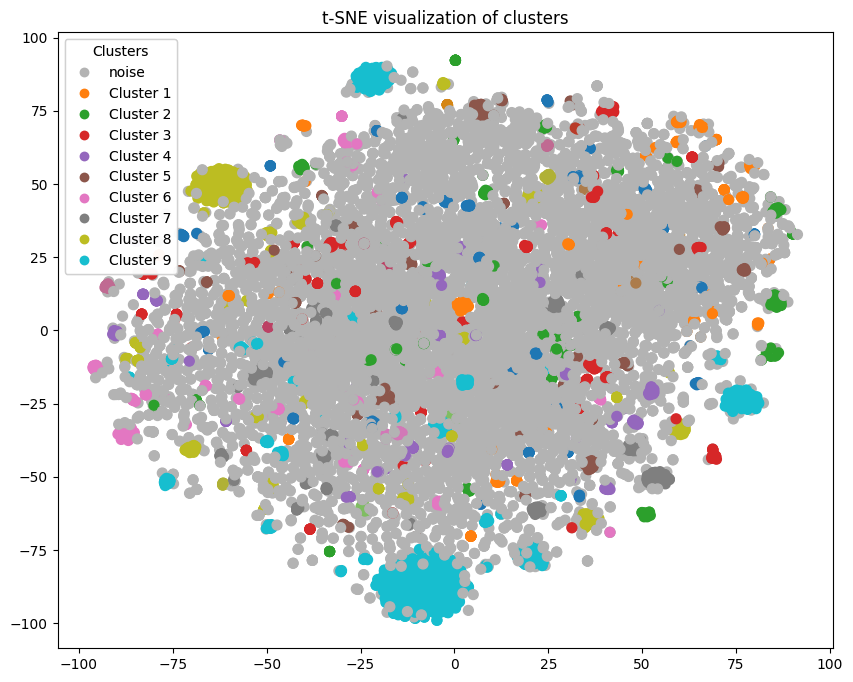

In [99]:
# Perform t-SNE on the embeddings
tsne = TSNE(n_components=2, metric='precomputed', init='random', random_state=42)
embeddings_2d = tsne.fit_transform(cosine_dist_matrix)

# Add the 2D embeddings to the DataFrame
df_embeddings['x'] = embeddings_2d[:, 0]
df_embeddings['y'] = embeddings_2d[:, 1]

# Define the custom colormap
tab10_cmap = plt.get_cmap('tab10', np.unique(df_embeddings['cluster_label']).size - 1)
tab10_cmap_list = tab10_cmap(np.linspace(0, 1, np.unique(df_embeddings['cluster_label']).size - 1))
custom_cmap_list = np.vstack(([0.7, 0.7, 0.7, 1.], tab10_cmap_list))
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', custom_cmap_list)

# Plot the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_embeddings['x'], df_embeddings['y'], c=df_embeddings['cluster_label'], cmap=custom_cmap, s=50)
plt.title("t-SNE visualization of clusters")

# Add a legend for the cluster colors
labels = ["noise"] + [f"Cluster {i}" for i in range(1, len(np.unique(df_embeddings['cluster_label'])))]
handles, _ = scatter.legend_elements()
legend1 = plt.legend(handles, labels, loc="upper left", title="Clusters")
plt.gca().add_artist(legend1)

plt.show()


Number of faces clustered into noise: 7359


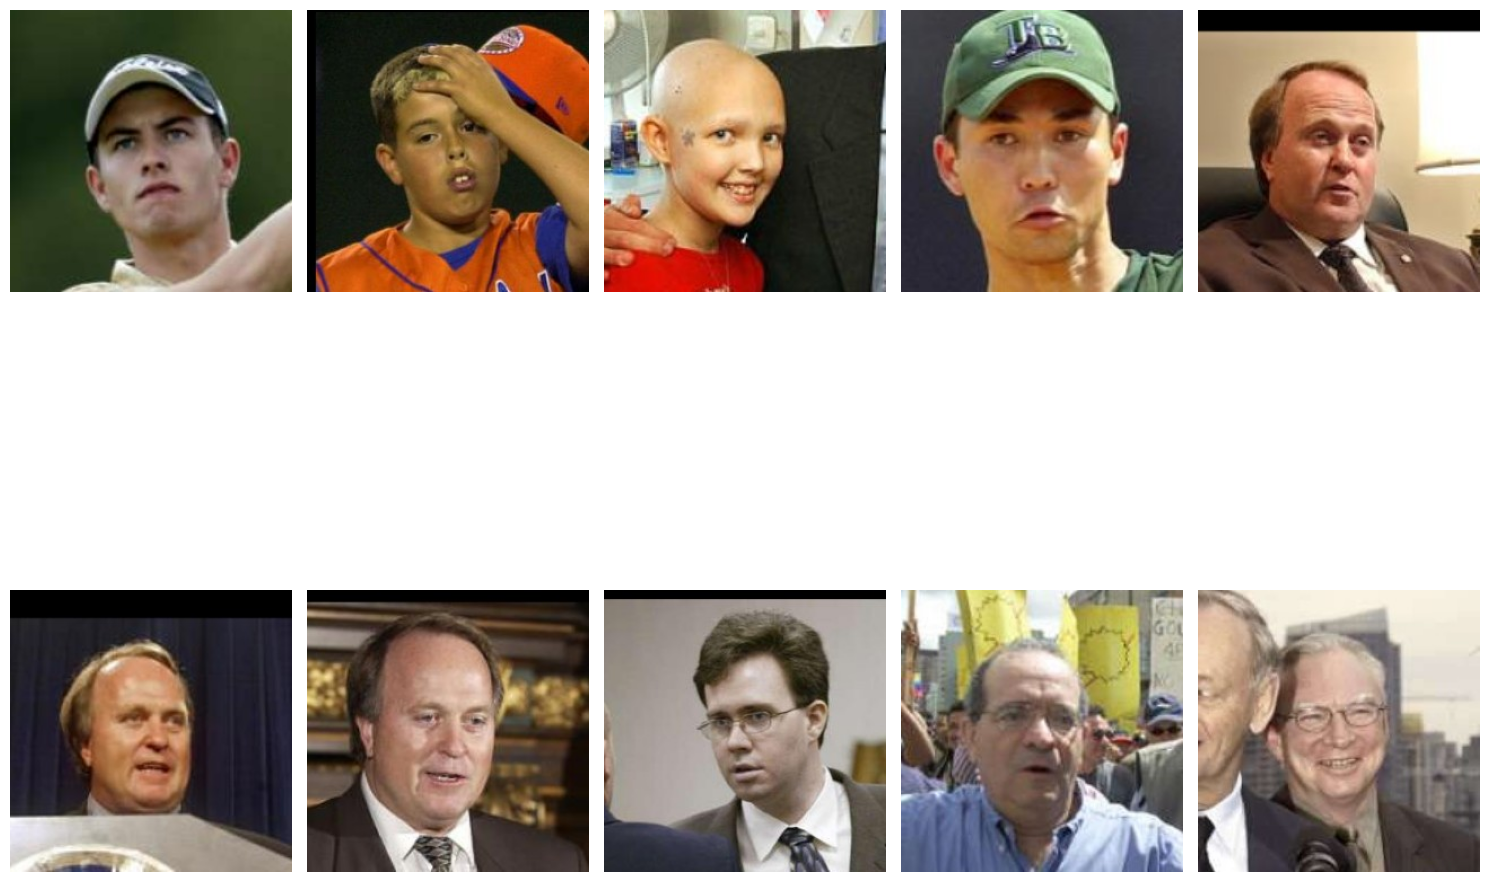

In [100]:
hdbscan_noise = list(df_embeddings[df_embeddings['cluster_label'] == -1]["original_index"].values)
print(f"Number of faces clustered into noise: {len(hdbscan_noise)}")
plot_original_faces(hdbscan_noise, max_faces=10)

## Clustering with DBSCAN

In [101]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances

In [102]:
# Perform DBSCAN clustering
dbscan_epsilon = 0.5 # 0.5 is default
dbscan_min_samples = 5 # 5 is default (integer values only)

temp = time.time()
dbscan = DBSCAN(eps=dbscan_epsilon, min_samples=dbscan_min_samples, metric='precomputed')
cluster_labels_dbscan = dbscan.fit_predict(cosine_dist_matrix)
dbscan_time = time.time() - temp

# Add the cluster labels as a new column in the DataFrame
df_embeddings['dbscan_cluster_label'] = cluster_labels_dbscan

In [104]:
true_names = [target_names[idx] for idx in original_indices]
true_labels_dbscan = np.zeros(len(true_names),dtype=np.int64) -1
first = 0
for idx, name in enumerate(true_names):
    if idx ==0:
        continue
    if name != true_names[idx-1]:
        try:
            true_labels_dbscan[first:idx] = int(np.argmax((np.bincount(cluster_labels_dbscan[first:idx]+1))[1:]))
        except(ValueError):
            true_labels_dbscan[first:idx] = -1
        first = idx    
try:
    true_labels_dbscan[first:] = int(np.argmax((np.bincount(cluster_labels_dbscan[first:]+1))[1:]))
except(ValueError):
    true_labels_dbscan[first:] = -1

In [105]:
cluster_labels_dbscan

array([ 0,  0, -1, ...,  0, -1, -1])

In [106]:
true_labels_dbscan

array([ 0,  0, -1, ...,  0, -1, -1])

In [107]:
cluster_labels_dbscan_correct = (cluster_labels_dbscan == true_labels_dbscan)
print(f"Results for the DBSCAN clustering:")
print(f"Number of different clusters: {len(np.unique(cluster_labels_dbscan))-1}")
print(f"Percentage of correctly clustered faces: {np.sum(cluster_labels_dbscan_correct)/len(cluster_labels_dbscan_correct)*100:.2f}%")
print(f"Percentage of correctly clustered faces (excluding noise): {np.sum(cluster_labels_dbscan_correct[cluster_labels_dbscan!=-1])/len(cluster_labels_dbscan_correct[cluster_labels_dbscan!=-1])*100:.2f}%")
print(f"Percentage of faces clustered into noise: {np.sum(cluster_labels_dbscan==-1)/len(cluster_labels_dbscan)*100:.2f}%")
print(f"Time needed for clustering: {dbscan_time:.2f}s")

Results for the DBSCAN clustering:
Number of different clusters: 20
Percentage of correctly clustered faces: 98.50%
Percentage of correctly clustered faces (excluding noise): 99.97%
Percentage of faces clustered into noise: 11.81%
Time needed for clustering: 2.36s


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


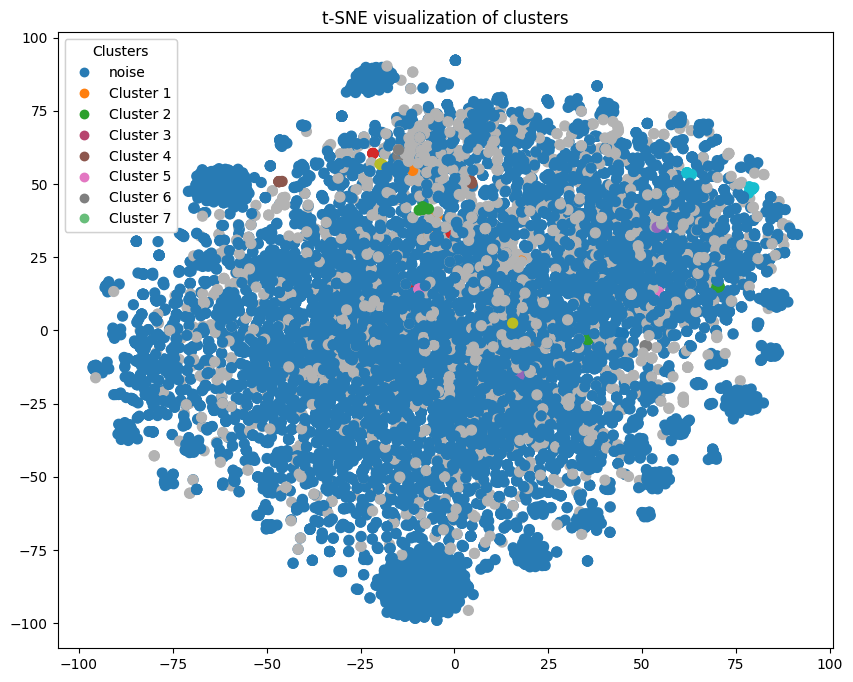

In [108]:
# Perform t-SNE on the embeddings
tsne = TSNE(n_components=2, metric='precomputed', init='random', random_state=42)
embeddings_2d = tsne.fit_transform(cosine_dist_matrix)

# Add the 2D embeddings to the DataFrame
df_embeddings['x'] = embeddings_2d[:, 0]
df_embeddings['y'] = embeddings_2d[:, 1]

# Define the custom colormap
tab10_cmap = plt.get_cmap('tab10', np.unique(df_embeddings['dbscan_cluster_label']).size - 1)
tab10_cmap_list = tab10_cmap(np.linspace(0, 1, np.unique(df_embeddings['dbscan_cluster_label']).size - 1))
custom_cmap_list = np.vstack(([0.7, 0.7, 0.7, 1.], tab10_cmap_list))
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', custom_cmap_list)

# Plot the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_embeddings['x'], df_embeddings['y'], c=df_embeddings['dbscan_cluster_label'], cmap=custom_cmap, s=50)
plt.title("t-SNE visualization of clusters")

# Add a legend for the cluster colors
labels = ["noise"] + [f"Cluster {i}" for i in range(1, len(np.unique(df_embeddings['dbscan_cluster_label'])))]
handles, _ = scatter.legend_elements()
legend1 = plt.legend(handles, labels, loc="upper left", title="Clusters")
plt.gca().add_artist(legend1)

plt.show()

Number of faces clustered into noise: 1446


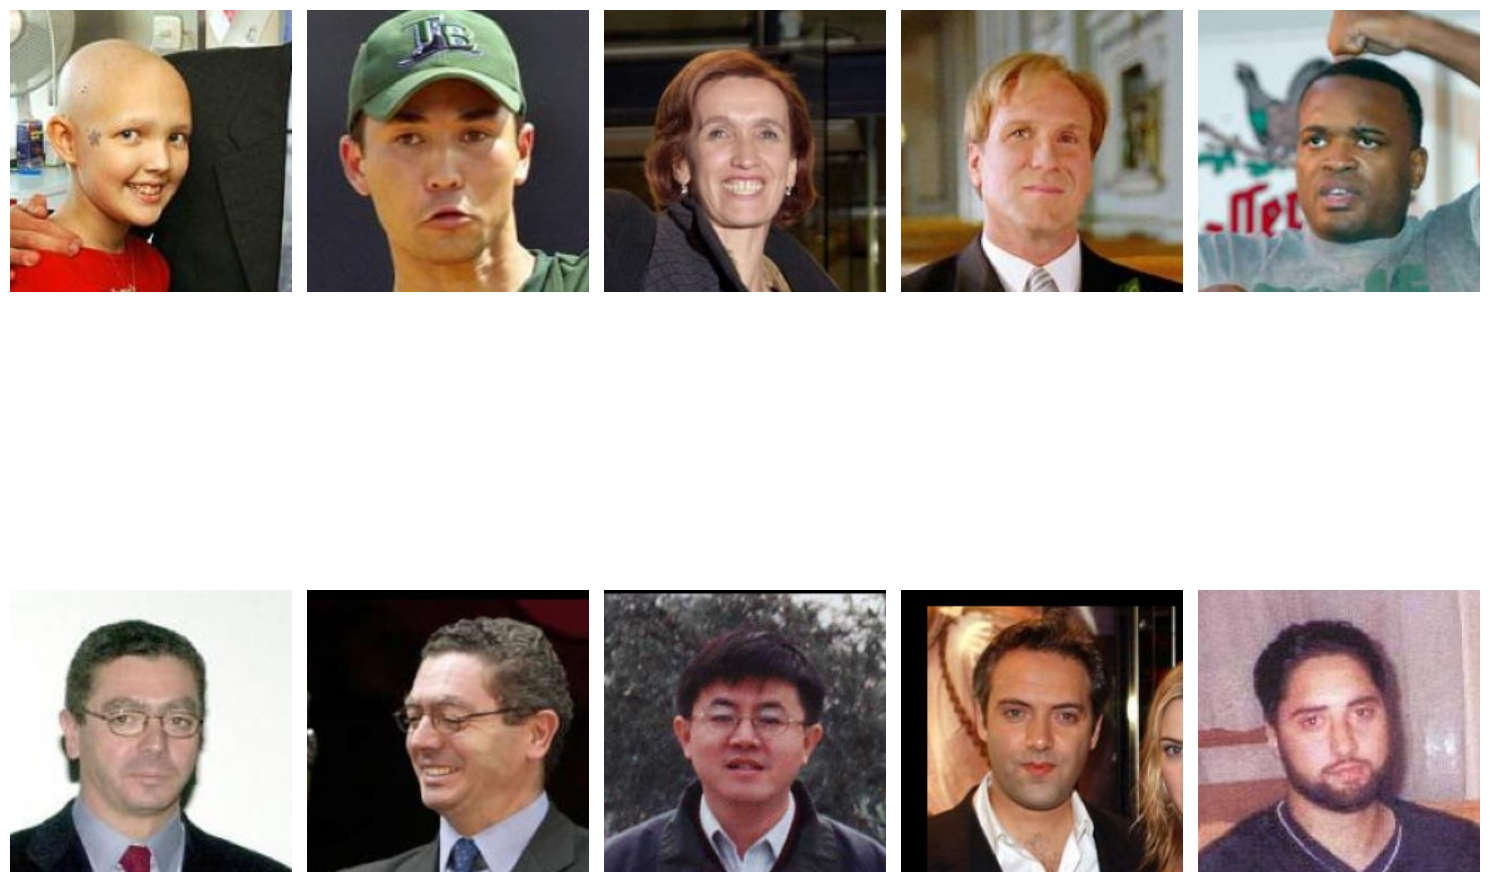

In [109]:
dbscan_noise = list(df_embeddings[df_embeddings['dbscan_cluster_label'] == -1]["original_index"].values)
print(f"Number of faces clustered into noise: {len(dbscan_noise)}")
plot_original_faces(dbscan_noise, max_faces=10)